# Project: Road Accidents in France based on Annual Road Traffic Accident Injury Database (2005 - 2023)

## Step 3: Final Model

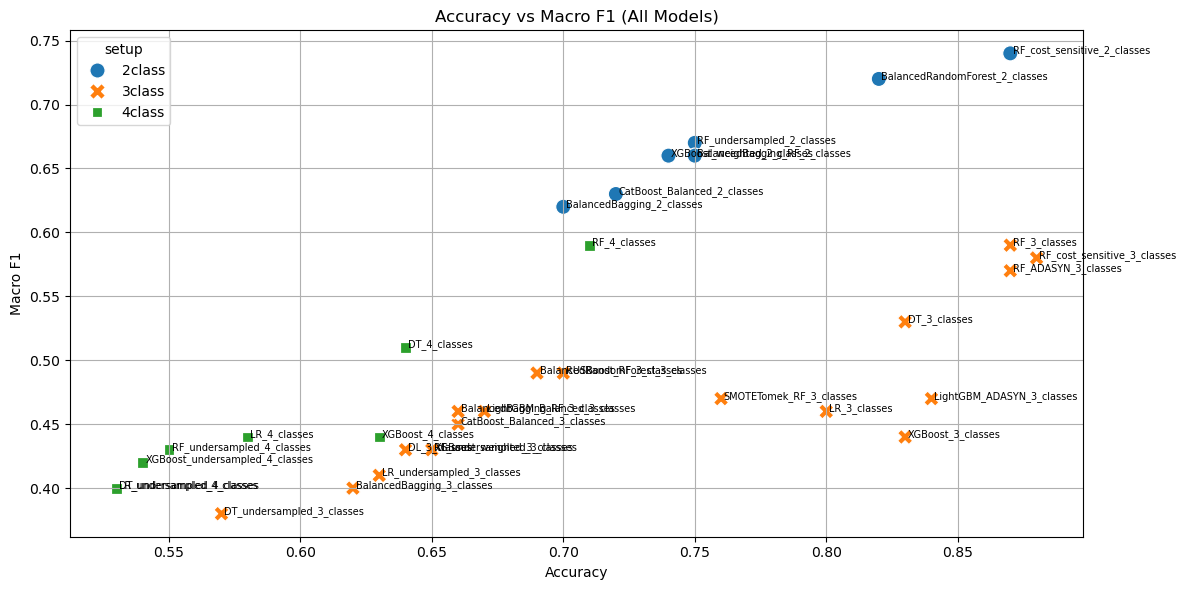

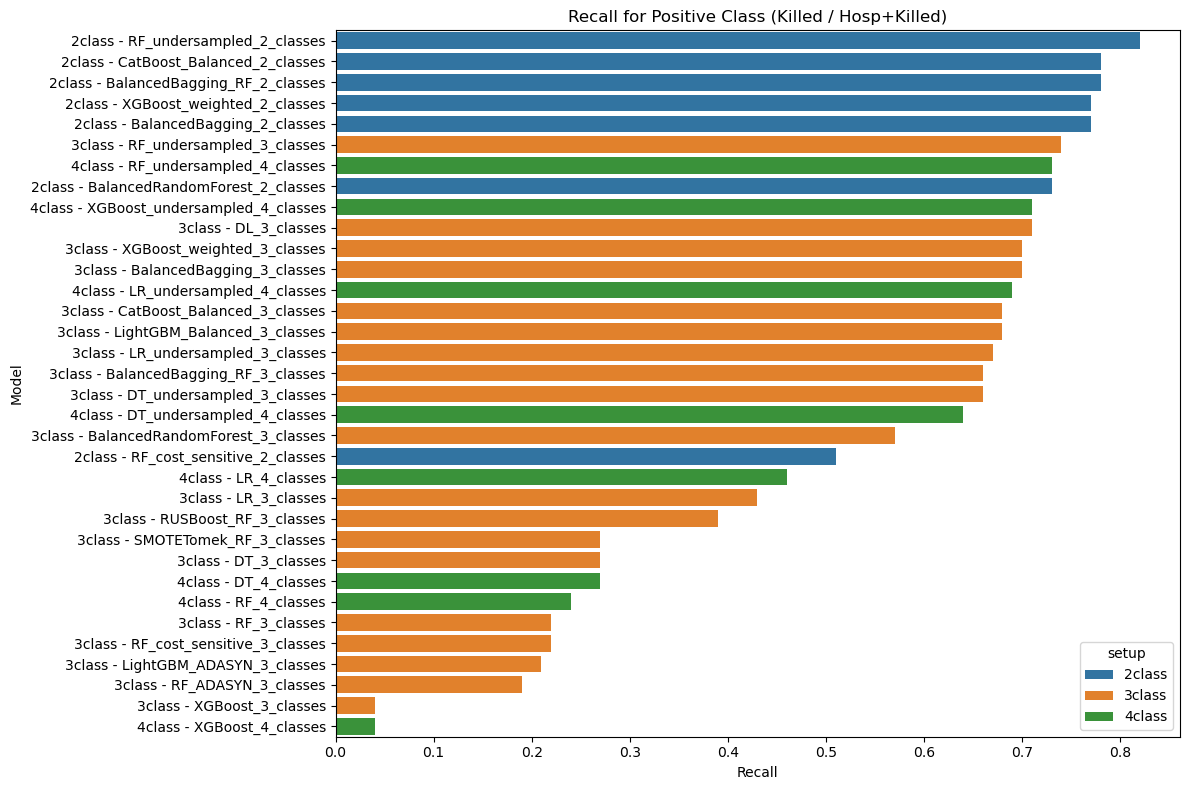

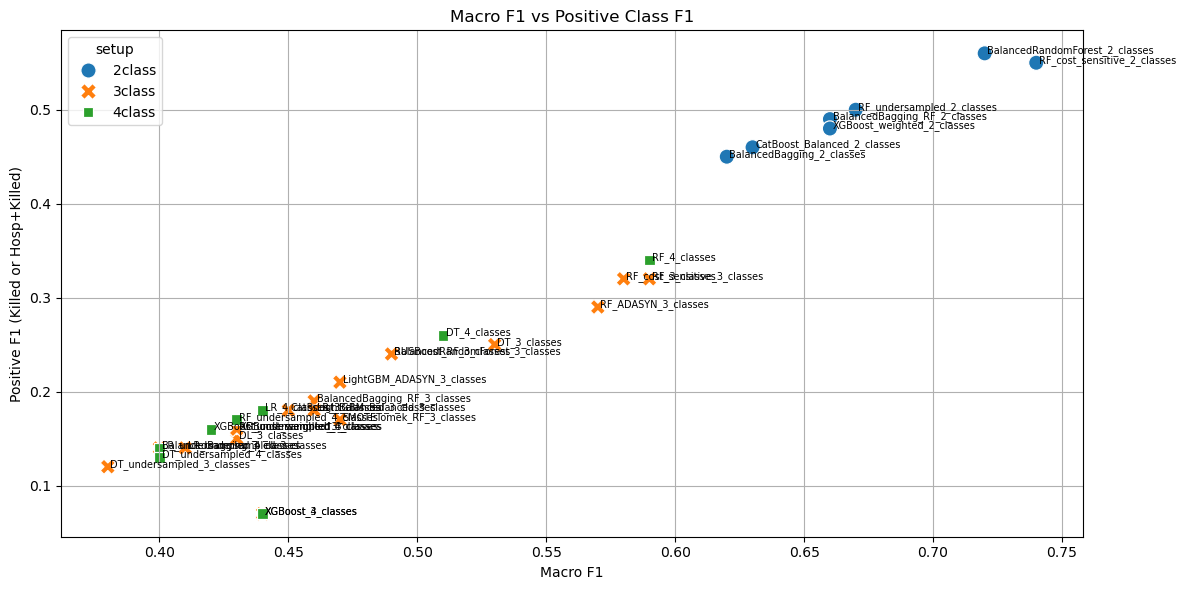

✅ All plots saved and rankings exported.


In [1]:
# 📦 Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📂 Load the metrics file
df = pd.read_csv("../reports/model_results.csv", sep=";")
df["model_display"] = df["setup"] + " - " + df["model"]

# 📊 --- Top N Rankings ---
ranking_df = df[["model", "setup", "accuracy", "macro_f1", "positive_precision", "positive_recall", "positive_f1"]].copy()

top_accuracy = ranking_df.sort_values("accuracy", ascending=False).head(5).assign(metric="accuracy")
top_macro_f1 = ranking_df.sort_values("macro_f1", ascending=False).head(5).assign(metric="macro_f1")
top_pos_recall = ranking_df.sort_values("positive_recall", ascending=False).head(5).assign(metric="positive_recall")
top_pos_f1 = ranking_df.sort_values("positive_f1", ascending=False).head(5).assign(metric="positive_f1")

# 📑 Combine all rankings
top_models = pd.concat([top_accuracy, top_macro_f1, top_pos_recall, top_pos_f1], ignore_index=True)

# 💾 Save rankings table
top_models.to_csv("../reports/top_model_rankings.csv", index=False)

# ==============================
# 📈 --- Plot 1: Accuracy vs Macro F1 ---
# ==============================
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="accuracy", y="macro_f1", hue="setup", style="setup", s=120)
for _, row in df.iterrows():
    plt.text(row["accuracy"] + 0.001, row["macro_f1"], row["model"], fontsize=7)
plt.title("Accuracy vs Macro F1 (All Models)")
plt.xlabel("Accuracy")
plt.ylabel("Macro F1")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("../reports/figures/accuracy_vs_macro_f1.png")
plt.close()

# ==============================
# 📈 --- Plot 2: Positive Recall ---
# ==============================
df_pos = df[df["positive_recall"].notna()]
plt.figure(figsize=(12, 8))
sns.barplot(data=df_pos.sort_values("positive_recall", ascending=False),
            x="positive_recall", y="model_display", hue="setup", dodge=False)
plt.title("Recall for Positive Class (Killed / Hosp+Killed)")
plt.xlabel("Recall")
plt.ylabel("Model")
plt.tight_layout()
plt.show()
plt.savefig("../reports/figures/positive_recall_barplot.png")
plt.close()

# ==============================
# 📈 --- Plot 3: Positive F1 vs Macro F1 ---
# ==============================
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_pos, x="macro_f1", y="positive_f1", hue="setup", style="setup", s=120)
for _, row in df_pos.iterrows():
    plt.text(row["macro_f1"] + 0.001, row["positive_f1"], row["model"], fontsize=7)
plt.title("Macro F1 vs Positive Class F1")
plt.xlabel("Macro F1")
plt.ylabel("Positive F1 (Killed or Hosp+Killed)")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("../reports/figures/positive_f1_vs_macro_f1.png")
plt.close()

print("✅ All plots saved and rankings exported.")




Class mapping: {'Hospitalized/Killed': 0, 'Minor/None': 1}

🔍 Grid searching BalancedRandomForest_2class_FULL_DATA ...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.60      0.84      0.70    172011
           1       0.97      0.90      0.93    930730

    accuracy                           0.89   1102741
   macro avg       0.79      0.87      0.82   1102741
weighted avg       0.91      0.89      0.90   1102741


🎯 Best threshold: 0.30 | Recall: 0.97, F1: 0.95


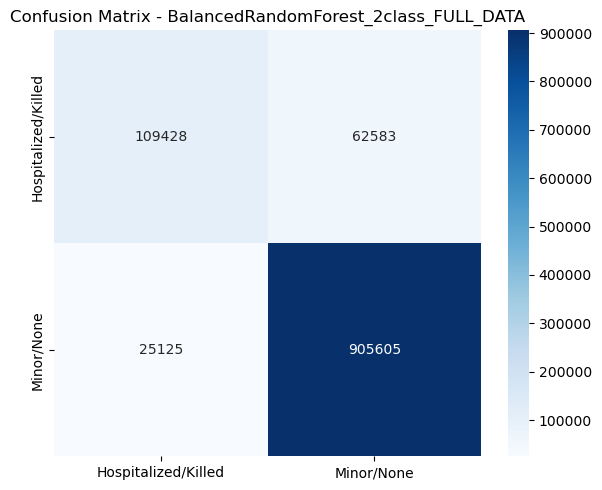

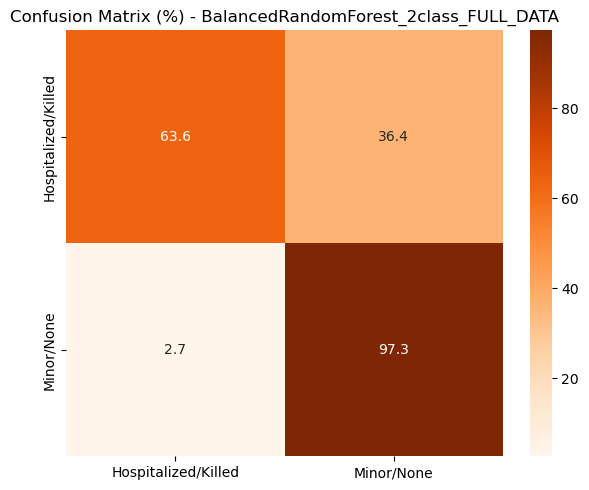


✅ All done. Model, results, and plots saved to ../models and ../reports/figures/


In [2]:
import warnings
warnings.filterwarnings('ignore')

# ========== Imports ==========
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

# ========== Load Data ==========
file_path = "../data/processed/df_for_ml.csv"
df = pd.read_csv(file_path, low_memory=False)

# ========== Preprocessing ==========
category_columns = [
    'lum', 'int', 'atm', 'col', 'circ', 'vosp', 'prof', 'plan', 'surf',
    'infra', 'situ', 'senc', 'obs', 'obsm', 'choc', 'catu', 'grav', 'sexe',
    'dayofweek', 'belt_status', 'agg_catr', 'catv_group', 'rush_hour',
    'season', 'age_bin', 'belt_user_type_code'
]
for col in category_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')

for col in ['nbv', 'age']:
    if col in df.columns:
        df[col] = df[col].astype('Int64')

if 'hour' in df.columns:
    df['hour'] = df['hour'].astype('int64')

# ========== Relabel for 2-class ==========
df["grav_label"] = df["grav"].map({1: "Minor/None", 2: "Hospitalized/Killed", 3: "Hospitalized/Killed", 4: "Minor/None"})

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["grav_label"])
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class mapping:", class_mapping)

X = df.drop(columns=["grav", "grav_label"])

# ========== Split ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========== Preprocessor ==========
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_features),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
        ("vt", VarianceThreshold(threshold=0.01))
    ]), cat_features)
])

# ========== Model Setup ==========
model_name = "BalancedRandomForest_2class_FULL_DATA"
safe_name = model_name.lower().replace(" ", "_")

brf = BalancedRandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

pipeline = ImbPipeline([
    ("preprocessor", preprocessor),
    ("classifier", brf)
])

param_grid = {
    "classifier__max_depth": [10, 20, None],
    "classifier__min_samples_split": [2, 5]
}

# ========== Grid Search ==========
print(f"\n🔍 Grid searching {model_name} ...")
search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=1,
    verbose=1
)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
probas = search.predict_proba(X_test)[:, 1]

print(f"✅ Best params: {search.best_params_}")
print(classification_report(y_test, y_pred))

# ========== Threshold Tuning ==========
thresholds = np.linspace(0.05, 0.95, 19)
best = {"threshold": 0.5, "recall": 0, "precision": 0, "f1": 0}

for t in thresholds:
    y_thr = (probas >= t).astype(int)
    prec = precision_score(y_test, y_thr)
    rec = recall_score(y_test, y_thr)
    f1 = f1_score(y_test, y_thr)
    if rec >= 0.70 and f1 > best["f1"]:
        best.update({"threshold": float(t), "recall": rec, "precision": prec, "f1": f1})

print(f"\n🎯 Best threshold: {best['threshold']:.2f} | Recall: {best['recall']:.2f}, F1: {best['f1']:.2f}")

# Final predictions
y_final = (probas >= best["threshold"]).astype(int)

# ========== Confusion Matrices ==========
labels = ["Hospitalized/Killed", "Minor/None"]
cm = confusion_matrix(y_test, y_final)
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

os.makedirs("../reports/figures", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# Raw confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title(f"Confusion Matrix - {model_name}")
plt.tight_layout()
plt.savefig(f"../reports/figures/{model_name}_confusion_matrix.png")
plt.show()
plt.close()

# Normalized confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pct, annot=True, fmt=".1f", cmap="Oranges", xticklabels=labels, yticklabels=labels)
plt.title(f"Confusion Matrix (%) - {model_name}")
plt.tight_layout()
plt.savefig(f"../reports/figures/{model_name}_confusion_matrix_percent.png")
plt.show()
plt.close()

# ========== Save Results ==========
results = {
    "model_name": model_name,
    "best_params": search.best_params_,
    "best_threshold": best,
    "classification_report": classification_report(y_test, y_final, output_dict=True),
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_percent": cm_pct.tolist()
}

# Save model and results
joblib.dump(search.best_estimator_, f"../models/model_{model_name}.joblib")
with open(f"../models/results_{model_name}.json", "w") as f:
    json.dump(results, f, indent=2)

# Save for Streamlit
streamlit_data = {
    model_name: {
        "confusion_matrix": results["confusion_matrix"],
        "confusion_matrix_percent": results["confusion_matrix_percent"]
    }
}
with open(f"../models/streamlit_confusion_matrices_{safe_name}.json", "w") as f:
    json.dump(streamlit_data, f)

print(f"\n✅ All done. Model, results, and plots saved to ../models and ../reports/figures/")


In [9]:
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import os, json
import numpy as np
import pandas as pd

print("\n💡 Generating full LIME explanations suite...")

model_name = "BalancedRandomForest_2class_FULL_DATA"
safe_name = model_name.lower().replace(" ", "_")
lime_dir = f"../reports/lime/{safe_name}"
os.makedirs(lime_dir, exist_ok=True)

# ========== Raw Data Prep ==========
X_train_lime = X_train.copy()
X_test_lime  = X_test.copy()

cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64", "Int64"]).columns.tolist()

# Step 1: Convert categorical columns to string for the model predict_fn
for c in cat_features:
    X_train_lime[c] = X_train_lime[c].astype(str).fillna("NaN")
    X_test_lime[c] = X_test_lime[c].astype(str).fillna("NaN")
for c in num_features:
    X_train_lime[c] = pd.to_numeric(X_train_lime[c], errors="coerce")
    X_test_lime[c] = pd.to_numeric(X_test_lime[c], errors="coerce")

# Step 2: Encode categoricals for LIME input (numeric only)
X_train_lime_enc = X_train_lime.copy()
X_test_lime_enc  = X_test_lime.copy()

for c in cat_features:
    all_vals = pd.concat([X_train_lime[c], X_test_lime[c]]).astype(str).fillna("NaN").unique()
    mapping = {k: i for i, k in enumerate(all_vals)}
    X_train_lime_enc[c] = X_train_lime[c].map(mapping).astype(float)
    X_test_lime_enc[c]  = X_test_lime[c].map(mapping).astype(float)

feature_names = list(X_test_lime_enc.columns)
cat_idx = [feature_names.index(c) for c in cat_features]
class_names = ["Hospitalized/Killed", "Minor/None"]

# ========== LIME Explainer ==========
X_bg = X_train_lime_enc.sample(n=min(200, len(X_train_lime_enc)), random_state=42)
explainer = LimeTabularExplainer(
    training_data=X_bg.values,
    feature_names=feature_names,
    class_names=class_names,
    categorical_features=cat_idx,
    mode="classification",
    sample_around_instance=True
)

# ========== Predict Function ==========
def lime_predict_fn(X_array):
    X_df = pd.DataFrame(X_array, columns=feature_names)
    for c in cat_features:
        X_df[c] = X_df[c].astype(str)
    for c in num_features:
        X_df[c] = pd.to_numeric(X_df[c], errors="coerce")
    return search.best_estimator_.predict_proba(X_df)

# ========== Thresholded Predictions ==========
threshold = best["threshold"]
y_pred_thr = (probas >= threshold).astype(int)

# ========== Case Groups ==========
idx_fn = np.where((y_test == 1) & (y_pred_thr == 0))[0][:3]  # False Negatives
idx_fp = np.where((y_test == 0) & (y_pred_thr == 1))[0][:3]  # False Positives
idx_tp = np.where((y_test == 1) & (y_pred_thr == 1))[0][:3]  # True Positives
idx_risk = np.argsort(probas)[-3:][::-1]                    # Top 3 High Risk

cases = {
    "false_negatives": idx_fn,
    "false_positives": idx_fp,
    "true_positives": idx_tp,
    "high_risk": idx_risk
}

lime_summaries = []

for case_type, indices in cases.items():
    print(f"🔎 Explaining {case_type.replace('_', ' ')}...")
    for i in indices:
        row = X_test_lime_enc.values[i]

        exp = explainer.explain_instance(
            data_row=row,
            predict_fn=lime_predict_fn,
            num_features=10
        )

        base = f"{lime_dir}/lime_{safe_name}_{case_type}_idx{i}"
        exp.save_to_file(base + ".html")
        fig = exp.as_pyplot_figure()
        fig.tight_layout()
        fig.savefig(base + ".png", dpi=200)
        plt.close(fig)

        lime_summaries.append({
            "index": int(i),
            "case_type": case_type,
            "y_true": int(y_test[i]),
            "predicted": int(y_pred_thr[i]),
            "proba_positive": float(probas[i]),
            "explanation": [
                {"feature": feat, "weight": float(weight)} for feat, weight in exp.as_list()
            ]
        })

# ========== Save JSON Summary ==========
summary_path = f"{lime_dir}/lime_streamlit_summary.json"
with open(summary_path, "w") as f:
    json.dump(lime_summaries, f, indent=2)

print(f"\n✅ LIME explanations complete. Saved to:\n- HTML/PNG: {lime_dir}\n- JSON Summary: {summary_path}")



💡 Generating full LIME explanations suite...
🔎 Explaining false negatives...
🔎 Explaining false positives...
🔎 Explaining true positives...
🔎 Explaining high risk...

✅ LIME explanations complete. Saved to:
- HTML/PNG: ../reports/lime/balancedrandomforest_2class_full_data
- JSON Summary: ../reports/lime/balancedrandomforest_2class_full_data/lime_streamlit_summary.json


In [7]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json

print("\n⚡ Running SHAP suite with force-aligned samples...")

# ========== Setup ==========
model = search.best_estimator_
model_name = "BalancedRandomForest_2class_FULL_DATA"
safe_name = model_name.lower().replace(" ", "_")
shap_dir = f"../reports/shap/{safe_name}"
os.makedirs(shap_dir, exist_ok=True)

# ========== Extract pipeline ==========
preprocessor = model.named_steps["preprocessor"]
classifier = model.named_steps["classifier"]

# ========== Get predictions ==========
threshold = best["threshold"]
probas = model.predict_proba(X_test)[:, 1]
y_pred_thr = (probas >= threshold).astype(int)

# ========== Select force plot cases ==========
idx_fn   = np.where((y_test == 1) & (y_pred_thr == 0))[0][:3]
idx_fp   = np.where((y_test == 0) & (y_pred_thr == 1))[0][:3]
idx_tp   = np.where((y_test == 1) & (y_pred_thr == 1))[0][:3]
idx_risk = np.argsort(probas)[-3:][::-1]

force_indices = np.unique(np.concatenate([idx_fn, idx_fp, idx_tp, idx_risk]))
X_sample_raw = X_test.iloc[force_indices].copy()
X_sample_numeric = preprocessor.transform(X_sample_raw)
if hasattr(X_sample_numeric, "toarray"):
    X_sample_numeric = X_sample_numeric.toarray()

# ========== SHAP background ==========
X_bg_raw = X_train.sample(n=1000, random_state=42)
X_bg_transformed = preprocessor.transform(X_bg_raw)
if hasattr(X_bg_transformed, "toarray"):
    X_bg_transformed = X_bg_transformed.toarray()
X_bg = shap.kmeans(X_bg_transformed, 25)

# ========== SHAP explainer ==========
explainer = shap.KernelExplainer(classifier.predict_proba, X_bg)
shap_values = explainer.shap_values(X_sample_numeric)
shap_vals_class1 = shap_values[:, :, 1]

# ========== Feature names ==========
feature_names = preprocessor.get_feature_names_out()

# ========== Summary plot ==========
summary_path = f"{shap_dir}/shap_summary_plot.png"
shap.summary_plot(shap_vals_class1, X_sample_numeric, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(summary_path, dpi=200)
plt.close()
print(f"✅ Saved summary plot: {summary_path}")

# ========== Bar plot ==========
# ========== Bar plot ==========
bar_path = f"{shap_dir}/shap_bar_plot.png"
bar_explanation = shap.Explanation(
    values=shap_vals_class1,
    base_values=explainer.expected_value[1],
    data=X_sample_numeric,
    feature_names=feature_names
)
shap.plots.bar(bar_explanation, show=False)
plt.tight_layout()
plt.savefig(bar_path, dpi=200)
plt.close()
print(f"✅ Saved bar plot: {bar_path}")

# ========== Violin plot ==========
violin_path = f"{shap_dir}/shap_violin_plot.png"
shap.summary_plot(shap_vals_class1, X_sample_numeric, feature_names=feature_names, plot_type="violin", show=False)
plt.tight_layout()
plt.savefig(violin_path, dpi=200)
plt.close()
print(f"✅ Saved violin plot: {violin_path}")

# ========== Dependence + Interaction plot ==========
top_feat_idx = np.argsort(np.abs(shap_vals_class1).mean(0))[-1]
top_feat = feature_names[top_feat_idx]

dep_path = f"{shap_dir}/shap_dependence_{top_feat}.png"
shap.dependence_plot(top_feat, shap_vals_class1, X_sample_numeric, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(dep_path, dpi=200)
plt.close()
print(f"✅ Saved dependence plot: {dep_path}")

interaction_path = f"{shap_dir}/shap_interaction_{top_feat}.png"
shap.dependence_plot(top_feat, shap_vals_class1, X_sample_numeric, interaction_index='auto', feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(interaction_path, dpi=200)
plt.close()
print(f"✅ Saved interaction plot: {interaction_path}")

# ========== Heatmap ==========
heatmap_path = f"{shap_dir}/shap_heatmap.png"
plt.figure(figsize=(12, 8))
sns.heatmap(shap_vals_class1, cmap="coolwarm", center=0)
plt.title("SHAP Value Heatmap (Class 1)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.tight_layout()
plt.savefig(heatmap_path, dpi=200)
plt.close()
print(f"✅ Saved heatmap: {heatmap_path}")

# ========== Force plots & JSON summary ==========
cases = {
    "false_negatives": idx_fn,
    "false_positives": idx_fp,
    "true_positives": idx_tp,
    "high_risk": idx_risk
}

shap_summaries = []
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = pd.Series(y_test).reset_index(drop=True)
probas_reset = pd.Series(probas).reset_index(drop=True)

# Map global index → shap index
shap_idx_map = {idx: i for i, idx in enumerate(force_indices)}

for case_type, indices in cases.items():
    print(f"🔍 SHAP force plots for {case_type.replace('_', ' ')}...")
    for i in indices:
        shap_idx = shap_idx_map.get(i, None)
        if shap_idx is None:
            continue

        base = f"{shap_dir}/shap_force_{case_type}_idx{i}"
        shap.plots.force(
            explainer.expected_value[1],
            shap_vals_class1[shap_idx],
            X_sample_numeric[shap_idx],
            matplotlib=True,
            feature_names=feature_names,
            show=False
        )
        plt.tight_layout()
        plt.savefig(base + ".png", dpi=200)
        plt.close()

        shap_summaries.append({
            "index": int(i),
            "case_type": case_type,
            "y_true": int(y_test_reset[i]),
            "predicted": int(y_pred_thr[i]),
            "proba_positive": float(probas_reset[i]),
            "explanation": [
                {"feature": str(feature_names[j]), "shap_value": float(val)}
                for j, val in enumerate(shap_vals_class1[shap_idx])
                if abs(val) > 0.01
            ]
        })

# ========== Save JSON summary ==========
json_path = f"{shap_dir}/shap_streamlit_summary.json"
with open(json_path, "w") as f:
    json.dump(shap_summaries, f, indent=2)

print(f"\n✅ All SHAP visualizations and JSON summary saved to: {shap_dir}")



⚡ Running SHAP suite with force-aligned samples...


  File "C:\Users\jl\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\jl\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jl\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\jl\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


  0%|          | 0/12 [00:00<?, ?it/s]

✅ Saved summary plot: ../reports/shap/balancedrandomforest_2class_full_data/shap_summary_plot.png
✅ Saved bar plot: ../reports/shap/balancedrandomforest_2class_full_data/shap_bar_plot.png
✅ Saved violin plot: ../reports/shap/balancedrandomforest_2class_full_data/shap_violin_plot.png
✅ Saved dependence plot: ../reports/shap/balancedrandomforest_2class_full_data/shap_dependence_cat__belt_status_1.png
✅ Saved interaction plot: ../reports/shap/balancedrandomforest_2class_full_data/shap_interaction_cat__belt_status_1.png
✅ Saved heatmap: ../reports/shap/balancedrandomforest_2class_full_data/shap_heatmap.png
🔍 SHAP force plots for false negatives...
🔍 SHAP force plots for false positives...
🔍 SHAP force plots for true positives...
🔍 SHAP force plots for high risk...

✅ All SHAP visualizations and JSON summary saved to: ../reports/shap/balancedrandomforest_2class_full_data
